In [1]:
!pip install pydicom

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 1.4 MB/s eta 0:00:02
   ------------- -------------------------- 0.8/2.4 MB 1.3 MB/s eta 0:00:02
   ----------------- ---------------------- 1.0/2.4 MB 1.4 MB/s eta 0:00:01
   -------------------------- ------------- 1.6/2.4 MB 1.5 MB/s eta 0:00:01
   ----------------------------------- ---- 2.1/2.4 MB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 1.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [ ]:
device = torch.device("cpu")
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMG_SIZE = 128
BATCH_SIZE = 4
NUM_EPOCHS = 12
LR = 1e-3

RAW_DIR = "data/manually-added"
BASE_DIR = "data/siim_subset"
CLASSES = ["normal", "pneu"]

Using device: cpu


In [ ]:
def count_raw_images(raw_dir):
    counts = {}
    for cls in CLASSES:
        folder = os.path.join(raw_dir, cls)
        if not os.path.isdir(folder):
            counts[cls] = 0
        else:
            counts[cls] = len([
                f for f in os.listdir(folder)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ])
    return counts

raw_counts = count_raw_images(RAW_DIR)
print("Raw image counts:", raw_counts)

if raw_counts["normal"] < 1 or raw_counts["pneu"] < 1:
    raise ValueError("Please ensure RAW_DIR has images in 'normal/' and 'pneu/'.")


Raw image counts: {'normal': 20, 'pneu': 20}


In [11]:
if os.path.isdir(BASE_DIR):
    shutil.rmtree(BASE_DIR)

for split in ["train", "val"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(BASE_DIR, split, cls), exist_ok=True)

def stratified_split_and_copy(raw_dir, base_dir, train_ratio=0.8):
    for cls in CLASSES:
        src_folder = os.path.join(raw_dir, cls)
        files = [
            f for f in os.listdir(src_folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))
        ]
        files.sort()
        random.shuffle(files)

        n_total = len(files)
        n_train = max(1, int(n_total * train_ratio))
        train_files = files[:n_train]
        val_files   = files[n_train:]

        for split, split_files in [("train", train_files), ("val", val_files)]:
            dst_folder = os.path.join(base_dir, split, cls)
            for fname in split_files:
                shutil.copy(os.path.join(src_folder, fname),
                            os.path.join(dst_folder, fname))

stratified_split_and_copy(RAW_DIR, BASE_DIR, train_ratio=0.8)

def count_split(base_dir):
    out = {}
    for split in ["train", "val"]:
        out[split] = {}
        for cls in CLASSES:
            folder = os.path.join(base_dir, split, cls)
            out[split][cls] = len(os.listdir(folder))
    return out

print("Split counts:", count_split(BASE_DIR))


Split counts: {'train': {'normal': 16, 'pneu': 16}, 'val': {'normal': 4, 'pneu': 4}}


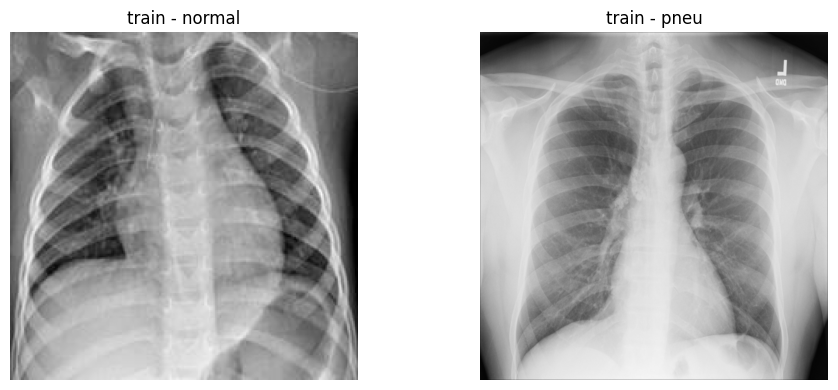

In [ ]:
def show_samples(split="train"):
    plt.figure(figsize=(10, 4))
    idx = 1
    for cls in CLASSES:
        folder = os.path.join(BASE_DIR, split, cls)
        files = os.listdir(folder)
        if not files:
            continue
        fname = random.choice(files)
        img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)

        plt.subplot(1, 2, idx)
        plt.imshow(img, cmap="gray")
        plt.title(f"{split} - {cls}")
        plt.axis("off")
        idx += 1
    plt.tight_layout()
    plt.show()

show_samples("train")

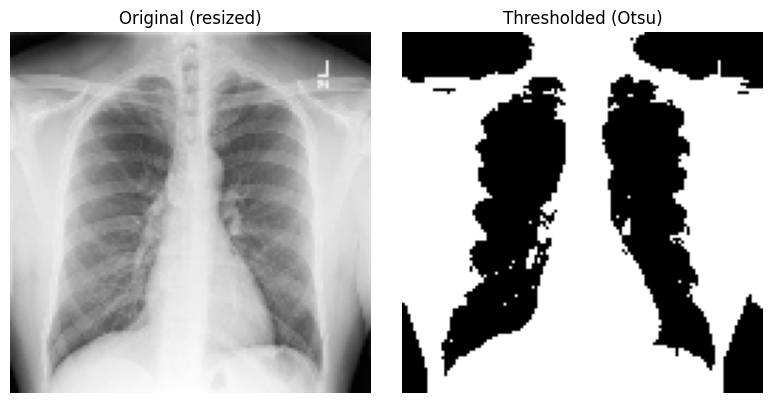

In [ ]:
def preprocess_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {path}")

    img = cv2.resize(img, (img_size, img_size))
    img_norm = img.astype(np.float32) / 255.0
    _, img_thresh = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    img_thresh = img_thresh.astype(np.float32) / 255.0

    return img_norm, img_thresh

pneu_train_folder = os.path.join(BASE_DIR, "train", "pneu")
if os.listdir(pneu_train_folder):
    example_path = os.path.join(pneu_train_folder, random.choice(os.listdir(pneu_train_folder)))
    orig, thr = preprocess_image(example_path, IMG_SIZE)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(orig, cmap="gray")
    plt.title("Original (resized)")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(thr, cmap="gray")
    plt.title("Thresholded (Otsu)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
class MedicalSpotDataset(Dataset):
    def __init__(self, root_dir, img_size=IMG_SIZE):
        self.root_dir = root_dir
        self.img_size = img_size
        self.classes = CLASSES
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        
        for cls in self.classes:
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                    self.samples.append((
                        os.path.join(folder, fname),
                        self.class_to_idx[cls]
                    ))

        print(f"Loaded {len(self.samples)} images from {root_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img_norm, img_thresh = preprocess_image(path, self.img_size)
        img_stack = np.stack([img_norm, img_thresh], axis=0)  # [2, H, W]
        return torch.from_numpy(img_stack).float(), torch.tensor(label).long()


In [ ]:
train_dataset = MedicalSpotDataset(os.path.join(BASE_DIR, "train"), img_size=IMG_SIZE)
val_dataset   = MedicalSpotDataset(os.path.join(BASE_DIR, "val"),   img_size=IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Loaded 32 images from data/siim_subset\train
Loaded 8 images from data/siim_subset\val
Train batches: 8
Val batches: 2


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, in_channels=2, num_classes=2):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN(in_channels=2, num_classes=len(CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print(model)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
train_loss_history = []
val_loss_history   = []
train_acc_history  = []
val_acc_history    = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total

    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_correct += (preds == labels).sum().item()
            val_running_total += labels.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_acc  = val_running_correct / val_running_total

    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    train_acc_history.append(epoch_train_acc)
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

Epoch [1/12] Train Loss: 0.7383 Acc: 0.5000 | Val Loss: 0.6792 Acc: 0.5000
Epoch [2/12] Train Loss: 0.6669 Acc: 0.7188 | Val Loss: 0.6375 Acc: 0.5000
Epoch [3/12] Train Loss: 0.5543 Acc: 0.7500 | Val Loss: 0.4757 Acc: 0.8750
Epoch [4/12] Train Loss: 0.3514 Acc: 0.9375 | Val Loss: 0.2615 Acc: 0.8750
Epoch [5/12] Train Loss: 0.1559 Acc: 0.9688 | Val Loss: 0.1515 Acc: 0.8750
Epoch [6/12] Train Loss: 0.0652 Acc: 1.0000 | Val Loss: 0.1102 Acc: 0.8750
Epoch [7/12] Train Loss: 0.0042 Acc: 1.0000 | Val Loss: 0.4758 Acc: 0.8750
Epoch [8/12] Train Loss: 0.2210 Acc: 0.9688 | Val Loss: 0.0601 Acc: 1.0000
Epoch [9/12] Train Loss: 0.2032 Acc: 0.9375 | Val Loss: 0.1080 Acc: 1.0000
Epoch [10/12] Train Loss: 0.0876 Acc: 1.0000 | Val Loss: 0.3740 Acc: 0.8750
Epoch [11/12] Train Loss: 0.0726 Acc: 0.9688 | Val Loss: 0.1216 Acc: 0.8750
Epoch [12/12] Train Loss: 0.0140 Acc: 1.0000 | Val Loss: 0.2163 Acc: 0.8750


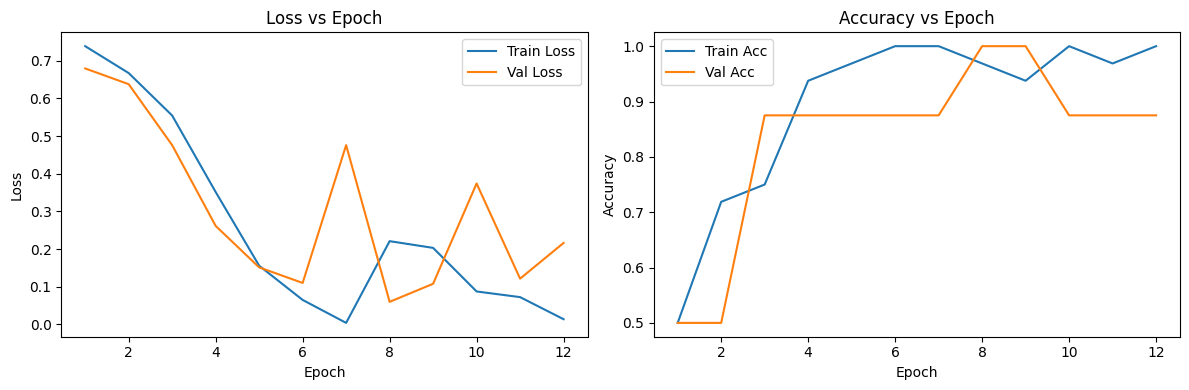

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label="Train Acc")
plt.plot(epochs, val_acc_history,   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy vs Epoch")
plt.legend()
plt.tight_layout()
plt.show()

Classification report:

              precision    recall  f1-score   support

      normal       1.00      0.75      0.86         4
        pneu       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

Confusion matrix:
 [[3 1]
 [0 4]]


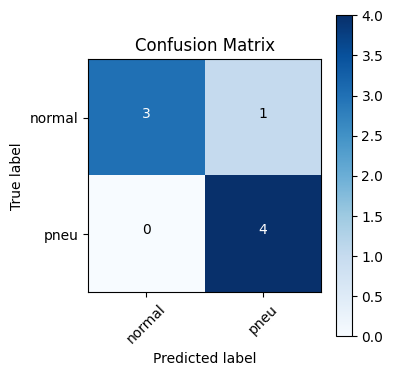

In [ ]:
model.eval()
all_labels = []
all_preds  = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

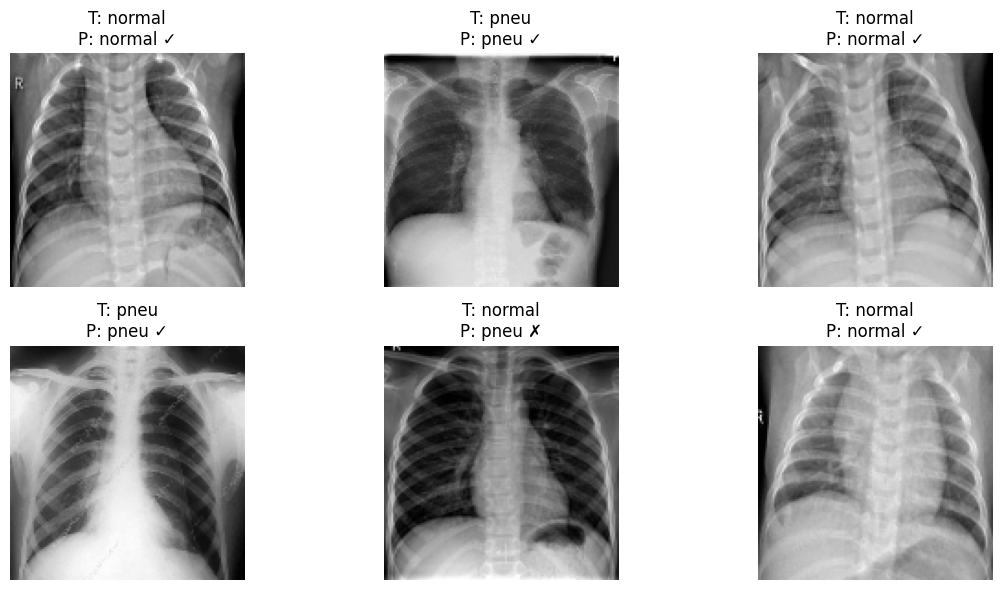

In [ ]:
def show_val_predictions(model, dataset, num_images=6):
    model.eval()
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:num_images]

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices, 1):
        img_tensor, label = dataset[idx]
        out = model(img_tensor.unsqueeze(0).to(device))
        _, pred = torch.max(out, 1)

        img_np = img_tensor[0].numpy()
        true_cls = CLASSES[label]
        pred_cls = CLASSES[pred.item()]
        correct = (true_cls == pred_cls)

        plt.subplot(2, (num_images + 1) // 2, i)
        plt.imshow(img_np, cmap="gray")
        plt.axis("off")
        plt.title(f"T: {true_cls}\nP: {pred_cls} {'✓' if correct else '✗'}")

    plt.tight_layout()
    plt.show()

show_val_predictions(model, val_dataset, num_images=6)